In [1]:
import os
os.chdir('../')

# Supplementary material: weight analysis on the effect of the scaling layer

In [2]:
from utils import *
from loader import *
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
import matplotlib.colors as colors

logging.disable(logging.CRITICAL)

In [3]:
path_data = "data-files/"
filename_species_names = "Xu-state-space-names.csv"
path_metadata = "metadata/"

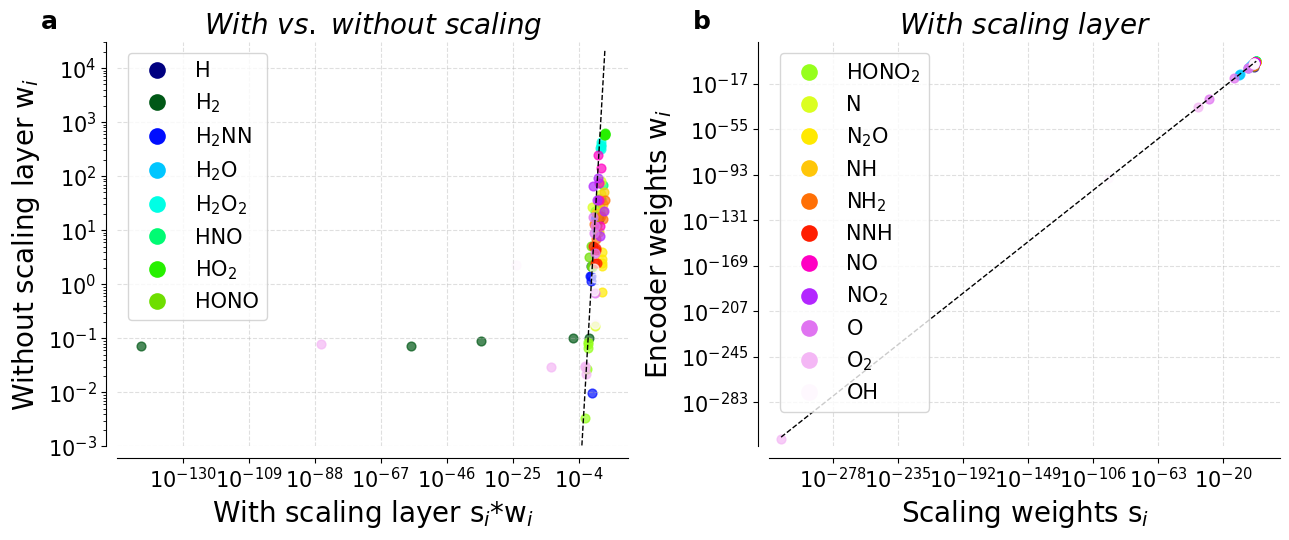

In [18]:
save = True
full = True
pathSave = "C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Scaling-layer/"
name = f"Suppl. mat. - weight analysis without and with scaling layer - complete range"
num_seeds = 5
species_weights_1 = {}  # First model set
species_weights_2 = {}  # Second model set

for seed in range(num_seeds):
    # --- First model ---
    filename_model_1 = f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s{seed}"
    filename_metadata_1 = filename_model_1 + "_metadata.pkl"
    loader1 = loadData(filename_species_names, path_metadata, filename_metadata_1)
    idx_species_removed1 = loader1.metadata["list idx species removed source"] if loader1.metadata["dataset_type"].startswith("autoignition_augm") else loader1.metadata["idx species removed"]
    model1 = loader1.loadModel()
    species_obj = Species(path_data)
    list_all_species = species_obj.get_list_species()
    list_input_species_1 = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed1]
    weights1 = np.abs(model1.get_total_encoder_weights().numpy().flatten())
    for sp, w in zip(list_input_species_1, weights1):
        species_weights_1.setdefault(sp, []).append(w)

    # --- Second model ---
    filename_model_2 = f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_25Mar2025-hour_09h57_Tr0D-2sW_s{seed}"
    filename_metadata_2 = filename_model_2 + "_metadata.pkl"
    loader2 = loadData(filename_species_names, path_metadata, filename_metadata_2)
    idx_species_removed2 = loader2.metadata["list idx species removed source"] if loader2.metadata["dataset_type"].startswith("autoignition_augm") else loader2.metadata["idx species removed"]
    model2 = loader2.loadModel()
    list_input_species_2 = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed2]
    weights2 = np.abs(model2.get_encoder_weights().numpy().flatten())
    for sp, w in zip(list_input_species_2, weights2):
        species_weights_2.setdefault(sp, []).append(w)

# Ensure consistent species order
species_names = sorted(set(species_weights_1.keys()) & set(species_weights_2.keys()))

fig, axes = plt.subplots(1, 2, figsize=(13, 5.5), sharex=False)
ax = axes[0]

cmap = cm.gist_ncar
norm = colors.Normalize(vmin=0, vmax=len(species_names) - 1)

for i, sp in enumerate(species_names):
    w1 = species_weights_1[sp]  # list over seeds
    w2 = species_weights_2[sp]  # list over seeds

    ax.scatter(
        w1, w2,
        s=40,
        alpha=0.7,
        color=cmap(norm(i))
    )

# Log–log axes
ax.set_xscale("log")
ax.set_yscale("log")

# Reference line y = x
xmin = min(min(v) for v in species_weights_1.values())
xmax = max(max(v) for v in species_weights_1.values())
ax.plot([xmin, xmax], [xmin, xmax], 'k--', linewidth=1)

ax.set_xlabel("With scaling layer s$_i$*w$_i$", fontsize=20)
ax.set_ylabel("Without scaling layer w$_i$", fontsize=20)

ax.set_title(r"$\mathit{With\ vs.\ without\ scaling}$", fontsize = 20)

if not full:
    ax.set_xlim([1e-3, 3e4]) #comment when full
ax.set_ylim([1e-3, 3e4])

ax.tick_params(axis='both', labelsize=15)
ax.grid(True, which="major", linestyle="--", alpha=0.4)

num_seeds = 5
scaling_weights_dict = {}
encoder_weights_dict = {}
species_weights_no_scaling = {}

# --- Collect data for WITH scaling layer (Tr35a) ---
for seed in range(num_seeds):
    filename_model = f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s{seed}"
    filename_metadata = filename_model + "_metadata.pkl"

    loader = loadData(filename_species_names, path_metadata, filename_metadata)
    idx_species_removed = loader.metadata["idx species removed"]
    model = loader.loadModel()

    species_obj = Species(path_data)
    list_all_species = species_obj.get_list_species()
    list_input_species = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed]

    scaling_weights = np.abs(model.get_scaling_weights().numpy().flatten())
    encoder_weights = np.abs(model.get_encoder_weights().numpy().flatten())

    for sp, sw, ew in zip(list_input_species, scaling_weights, encoder_weights):
        scaling_weights_dict.setdefault(sp, []).append(sw)
        encoder_weights_dict.setdefault(sp, []).append(ew)

ax2 = axes[1]

for i, sp in enumerate(scaling_weights_dict.keys()):
    sw = scaling_weights_dict[sp]   # scaling weights over seeds
    ew = encoder_weights_dict[sp]   # encoder weights over seeds

    ax2.scatter(
        sw, ew,
        s=40,
        alpha=0.7,
        color=cmap(norm(i))
    )

# Log–log axes
ax2.set_xscale("log")
ax2.set_yscale("log")

# Reference line y = x
xmin = min(min(v) for v in scaling_weights_dict.values())
xmax = max(max(v) for v in scaling_weights_dict.values())
ax2.plot([xmin, xmax], [xmin, xmax], 'k--', linewidth=1)

ax2.set_xlabel("Scaling weights s$_i$", fontsize=20)
ax2.set_ylabel("Encoder weights w$_i$", fontsize=20)

ax2.set_title(r"$\mathit{With\ scaling\ layer }$", fontsize = 20, fontweight = "bold")

if not full:
    ax2.set_xlim([1e-4, 1.5e2])  #comment when full
    ax2.set_ylim([1e-4, 1.5e2])  #comment when full
else:
    ax2.set_xlim(left=1e-320)  # force lower x-limit
    ax2.set_ylim(bottom=1e-320)  # force lower y-limit

ax2.tick_params(axis='both', labelsize=15)
ax2.grid(True, which="major", linestyle="--", alpha=0.4)

species_names = [string.replace('2', '$_2$') for string in species_names]

legend_handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=12,
        markerfacecolor=cmap(norm(i)),
        markeredgecolor='none',
        label=sp
    )
    for i, sp in enumerate(species_names[:int(len(species_names)/2)-1])
]

# Add a single legend for the whole figure
ax.legend(
    handles=legend_handles,
    loc="upper left",      # adjust as needed
    fontsize=15
)

legend_handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=12,
        markerfacecolor=cmap(norm(i+int(len(species_names)/2)-1)),
        markeredgecolor='none',
        label=sp
    )
    for i, sp in enumerate(species_names[int(len(species_names)/2)-1:])
]

# Add a single legend for the whole figure
ax2.legend(
    handles=legend_handles,
    loc="upper left",      # adjust as needed
    fontsize=15
)

if not full:
    text_x, text_y = 0.77, 0.229  # adjust as needed

    # Arrow target position (figure-relative coordinates)
    arrow_x, arrow_y = 0.785, 0.5  # points somewhere inside first subplot

    ax.annotate(
        "More extreme\nweights with scaling",
        fontsize = 15,
        ha = "center",
        xy=(arrow_x, arrow_y),
        xytext=(text_x, text_y),
        xycoords=ax.transAxes,
        textcoords=ax.transAxes,
        arrowprops=dict(
            arrowstyle="->",
            linewidth=1.8
        )
    )

    ellipse_center = (0.673, 0.31)   # (x, y) in [0,1]
    ellipse_width  = 0.1           # fraction of axis width
    ellipse_height = 0.42           # fraction of axis height

    ellipse = Ellipse(
        xy=ellipse_center,
        width=ellipse_width,
        height=ellipse_height,
        edgecolor="k",
        facecolor="none",
        linestyle = "--",
        linewidth=1.8,
        transform=ax2.transAxes
    )

    ax2.add_patch(ellipse)

    # === Text to the right of the ellipse ===
    text_x = ellipse_center[0] + ellipse_width / 2 + 0.03
    text_y = ellipse_center[1]

    ax2.text(
        text_x, text_y,
        r"2$^{\mathrm{nd}}$ mode",
        transform=ax2.transAxes,
        fontsize=15,
        ha="left",
        va="center"
    )

for i in range(len(axes)):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    if full:
        offset_left = 8
        offset_bottom = 8
        axes[i].spines['left'].set_position(('outward', offset_left))
        axes[i].spines['bottom'].set_position(('outward', offset_bottom))

plt.tight_layout()

def add_panel_label(ax, label, x_offset=-0.15, y_offset=1.08, fontsize=18):
    ax.text(
        x_offset, y_offset,
        label,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight="bold",
        va="top",
        ha="left",
        clip_on=False
    )
add_panel_label(axes[0], "a")
add_panel_label(axes[1], "b")

if save:
    plt.savefig(pathSave + name + ".png", dpi=1000, bbox_inches="tight")
    plt.savefig(pathSave + name + ".pdf", bbox_inches="tight")

plt.show()